* **Take normal images of faces and use OpenCV and dlib to add face masks to them**
    * Start with an image of a person not wearing a face mask
    * Apply face detection to compute the bounding box of the face in the image
    * Detect facial landmarks 
    * Next, we need an image of a mask (with a transparent background)
    * Use the facial landmarks to compute where the mask should be placed and apply it to the face
    * Resize and rotate the mask and place it on the face
    
Note : If you use a set of images to create an artificial dataset of people wearing masks, you cannot **re-use** the images without masks in your training set — you still need to gather non-face mask images that were not used in the artificial generation process! <br>
If you include the original images used to generate face mask samples as non-face mask samples, your model will become heavily biased and fail to generalize well.

In [1]:
# import the necessary packages
import numpy as np
import pandas as pd
import cv2
import os
import dlib
import matplotlib.pyplot as plt
from matplotlib.image import imread

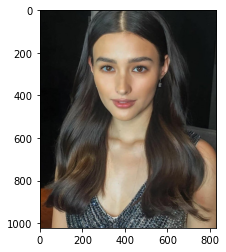

In [2]:
# Start with an image of a person not wearing a face mask

directory = os.path.join(os.getcwd(), "sample images")
file_name = os.path.join(directory, "0.jpg")
img = imread(file_name)
plt.imshow(img)
plt.show()

In [3]:
# Apply face detection to compute the bounding box of the face in the image

# initialize dlib’s pre-trained face detector
detector = dlib.get_frontal_face_detector()
# load image in grayscale mode
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
# detect faces in the grayscale image
faces = detector(gray, 1)
faces

rectangles[[(204, 162) (589, 547)]]

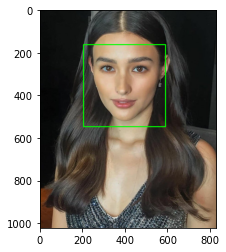

In [4]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the OpenCV format (x, y, w, h) 
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

# show detected faces
for rect in faces:
    (x, y, w, h) = rect_to_bb(rect)
    img_ = img.copy()
    img_ = cv2.rectangle(img_,(x,y),(x+w,y+h),(0,255,0),3)
    
plt.imshow(img_)
plt.show()

**Visualization of the face landmark locations:**
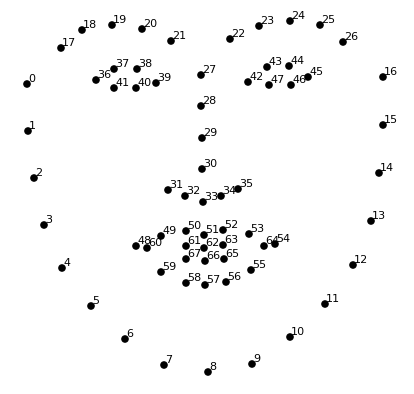

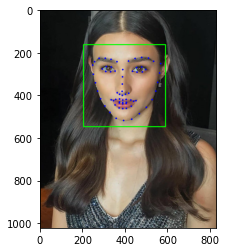

In [5]:
# Detect facial landmarks

# initialize facial landmark predictor
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)    
    # loop over the 68 facial landmarks and convert them to a tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # return the list of (x, y)-coordinates
    return coords

for rect in faces:
        # Get the landmark points
        shape = predictor(gray, rect)
        # Convert it to the NumPy Array
        shape = shape_to_np(shape)
        # Display the landmarks
        for (x, y) in shape:
            cv2.circle(img_, (x, y), 4, (0, 0, 255), -1)

# Display the image
plt.imshow(img_)
plt.show()

* Facial landmarks to apply the mask
    * 29 
    * 1 to 15 

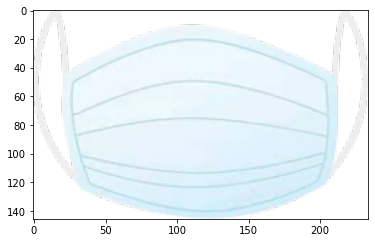

In [6]:
# an image of a mask (with a transparent background)
file_name = os.path.join(directory, "mask.png")
mask = imread(file_name)
plt.imshow(mask)
plt.show()

**Annotating Key Points on the Mask Image** <br>
For better alignment, we need to annotate mask points that correspond to the chosen landmarks from the face.<br>
Open-source online tool for performing such annotations <a href = "https://www.makesense.ai/">Make Sense</a><br>
Save annotations to a csv file

In [7]:
mask_annotations = pd.read_csv("mask_annotations.csv", usecols=[0, 1, 2], names=["Landmark", "x-coordinate", "y-coordinate", "3", "4", "5"])
mask_annotations

,Landmark,x-coordinate,y-coordinate
0,1,23,45
1,8,118,145
2,15,210,44
3,29,113,11
4,5,35,124
5,11,205,119
6,6,60,135
7,7,88,142
8,9,152,142
9,10,178,134


In [8]:
# use the facial landmarks to infer the facial structures, rotate and resize the mask,
# and then apply it to the image

facial_landmarks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 29]


destination_points = np.array([ shape[x] for x in facial_landmarks ],
    dtype="float32",
)


source_pts = []
for x in facial_landmarks:
    annotations = mask_annotations[mask_annotations["Landmark"] == x]
    x_ = float(annotations["x-coordinate"])
    y_ = float(annotations["y-coordinate"])
    
    source_pts.append(np.array([x_, y_]))
source_pts = np.array(source_pts, dtype="float32")

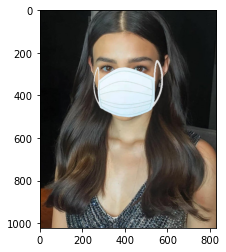

In [9]:
# load mask image
mask_img = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
mask_img = cv2.cvtColor(mask_img, cv2.COLOR_RGBA2BGR)
mask_img = mask_img.astype(np.float32)
mask_img = mask_img / 255.0

# get the perspective transformation matrix
M, _ = cv2.findHomography(source_pts, destination_points )

# transformed mask image
result = img.astype(np.float32) / 255.0
transformed_mask = cv2.warpPerspective(
                                mask_img,
                                M,
                                (result.shape[1], result.shape[0])
                                        )

# mask overlay
alpha_mask = transformed_mask[:, :, 2]
alpha_image = 1.0 - alpha_mask

for c in range(0, 3):   

    result[:, :, c] = (
        alpha_mask * transformed_mask[:, :, c]
        + alpha_image * result[:, :, c]
    )


# display the resulting image
plt.imshow(result)
plt.show()

A similar Dataset is available on : <a href = "https://github.com/cabani/MaskedFace-Net">cabani</a>   or 
<a href = "https://github.com/prajnasb/observations/tree/master/experiements/data">prajnasb</a> 
We will use this instead. <br>
And some real dataset <a href = "https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset">kaggle</a>
